# Idea

I imagine that these are 65-channel image. I'm curious what information I can glean from a single pixel, so I treat this like a fundamental classification task where each pixel is a datapoint to be classified as ink/no ink without considering the surrounding information. 

In [2]:
from torch.utils.data import Dataset,DataLoader
import numpy as np
import os
import glob
import torch
import torch.nn as nn
from torch.nn import BCELoss
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
from tqdm import tqdm
from ipywidgets import interact, fixed

DEVICE = "cpu"

class VesuviusPointwiseData(Dataset):
    def __init__(self, train_dir, divx=6, divy=6, samples=None):
        if samples is None:
            self.train_samples = [(os.path.join(train_dir, sub), y, x) for sub in os.listdir(train_dir) for y in range(divy) for x in range(divx)]
        else:
            self.train_samples = [(os.path.join(train_dir, str(sub)), y, x) for sub in samples for y in range(divy) for x in range(divx)]
        self.train_dir = train_dir
        self.divx,self.divy = divx, divy

    def _div_xy(self, image : np.ndarray, cx : int, cy : int):
        
        sizey,sizex = image.shape[0],image.shape[1]
        return image[cy*sizey//self.divy:(cy+1)*sizey//self.divy , cx*sizex//self.divx:(cx+1)*sizex//self.divx]
    
    def _load_chunk(self, filename, cx, cy):
        with Image.open(filename) as i:
            image = np.array(i, dtype=np.float32)/65535.0
        return np.array(self._div_xy(image, cx, cy))

    def __len__(self):
        return len(self.train_samples)
    
    """
    dataset[idx] where idx < len(dataset) returns a sample in no particular order
    returns: 3d scan (DHW), segmentation (HW), mask (HW)
    """
    def __getitem__(self, idx : int):
        key, cy, cx = self.train_samples[idx]
        dir = key

        pattern = os.path.join(dir, "surface_volume", "*.tif")
        images = []
        for filename in sorted(glob.glob(pattern)): # Load and chunk each xray slice individually for memory savings.
            images.append(self._load_chunk(filename, cx, cy))
        with Image.open(os.path.join(dir, "mask.png")) as m,Image.open(os.path.join(dir, "inklabels.png")) as l:
            mask = np.array(m.convert('1'))
            mask = self._div_xy(mask, cx, cy)
            label = np.array(l)
            label = self._div_xy(label, cx, cy)

        return np.array(images), (label > 0)*1., (mask > 0)*1.

Let's start by visualizing the average at each pixel.

In [3]:
res = 0
for filename in sorted(glob.glob(os.path.join("/kaggle/input/vesuvius-challenge-ink-detection/train/1/surface_volume/*.tif"))):
    with Image.open(filename) as i:
        res += np.array(i, dtype=np.float32)/65535.0
        

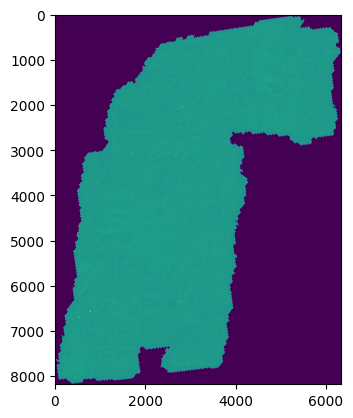

In [4]:
plt.imshow(res/65)

# Training

In [2]:

    
model = nn.Sequential(
    nn.Conv2d(65, 65, 1, 1), nn.ReLU(),
    nn.Conv2d(65, 1, 1, 1), nn.Sigmoid()
).to(DEVICE)
train_dataset = VesuviusPointwiseData("/kaggle/input/vesuvius-challenge-ink-detection/train", divx=5, divy=5, samples=["1", "2"])

In [ ]:
EPOCHS = 10

In [ ]:
DEVICE

In [ ]:
train_loader = data.DataLoader(train_dataset, shuffle=True)
optimizer = optim.Adam(model.parameters())
ce_loss = BCELoss()
for epoch in range(EPOCHS):
    for xray,label,mask in tqdm(train_loader, desc=f"Epoch {epoch}"):
        if label.max() < 0.5: continue
        xray = xray.to(DEVICE).float()
        label = label.to(DEVICE).float()
        mask = mask.to(DEVICE)
        res = model(xray)
        loss = ce_loss(res[0], label).mean()
        print(loss)
        loss.backward()
        optimizer.step()
        torch.save(model.state_dict(), f"/kaggle/working/e{epoch}")

# Validation

In [3]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import numpy as np
import os
import glob
import torch
import torch.nn as nn
from torch.nn import BCELoss
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed
model.load_state_dict(torch.load("pointwise_checkpoints/e9"))
val_dataset = VesuviusPointwiseData("vesuvius-challenge-ink-detection/train", divx=4, divy=4, samples=["3"])
val_loader = data.DataLoader(val_dataset)

with Image.open("vesuvius-challenge-ink-detection/train/3/inklabels.png") as i:
    full_res = np.zeros_like(np.array(i), dtype=np.float32)
    full_label = np.zeros_like(np.array(i), dtype=np.float32)
sizey,sizex = full_res.shape[0],full_res.shape[1]

i=0
for xray,label,mask in tqdm(val_loader):
    cx = i%4
    cy = i//4
    i+=1
    xray = xray.to(DEVICE).float()
    label = label.to(DEVICE).float()
    mask = mask.to(DEVICE)
    res = model(xray)
    full_res[cy*sizey//4:(cy+1)*sizey//4 , cx*sizex//4:(cx+1)*sizex//4] = res.cpu().detach().numpy()[0][0]
    full_label[cy*sizey//4:(cy+1)*sizey//4 , cx*sizex//4:(cx+1)*sizex//4] = label.cpu().detach().numpy()[0]

100%|██████████| 16/16 [04:33<00:00, 17.12s/it]


Visualize result

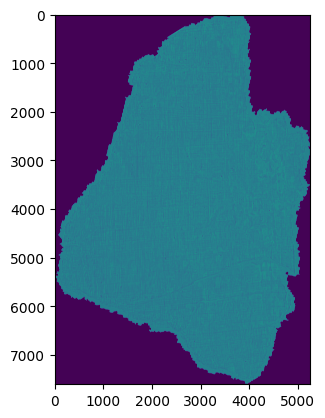

In [4]:
plt.imshow(full_res)